In [1]:
# imports 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import os 

porn_df = pd.read_csv('../data/xhamster.csv') # load Sexualitics raw csv
youtube_df = pd.DataFrame() # initialize empty df
for filename in os.listdir('../data/youtube'): 
    if filename != '.DS_Store':
        current_df = pd.read_csv('../data/youtube/%s' %filename)
        youtube_df = pd.concat([youtube_df,current_df], ignore_index=True)

In [2]:
# add porn column and remove extra headings

youtube_df["isPorn"] = pd.Series()
youtube_df=youtube_df.fillna(0)
youTubeTitles = youtube_df.loc[:, ["title", "isPorn"]]


In [3]:
porn_df["isPorn"] = pd.Series()
porn_df=porn_df.fillna(1)
pornTitles = porn_df.loc[:, ["title", "isPorn"]]

In [4]:
# use ast to turn "channels" string values into lists of tags
import ast
porn_time_tags = porn_df.loc[:, ["upload_date", "channels"]]

videoyears = []
tags = []
nodatetags = []
# Pull out years of videos
for i in porn_time_tags.values:
    if i[0] == 1:
        nodatetags.append(i[1])
    else:
        videoyears.append(i[0][:4])
        tags.append(ast.literal_eval(i[1]))



In [5]:
# make tag vocab library

alltags = []

for value in tags:
    alltags += value

# remove duplicates    
alltags = set(alltags)

#turn back into a list
alltags = list(alltags)

In [6]:
tags[0:3]

[['BBW', 'Black and Ebony', 'Interracial'],
 ['Masturbation'],
 ['Babes', 'Teens', 'Webcams']]

In [7]:
for i in tags[0:3]:
    if 'BBW' in i:
        print "yes"
    else:
        print "no"

yes
no
no


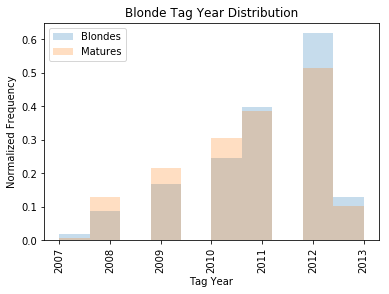

In [8]:
# make histogram for first two tags ("blondes" and "matures") as a test
alltags[0]

blondesyears = []
count=0
for i in tags:
    if alltags[0] in i:
        blondesyears.append(videoyears[count])
    count += 1

maturesyears = []
count=0
for i in tags:
    if alltags[1] in i:
        maturesyears.append(videoyears[count])
    count += 1

    
plt.hist(np.asarray(blondesyears), normed = True, alpha = 0.25, label = alltags[0])
plt.hist(np.asarray(maturesyears), normed = True, alpha = 0.25, label = alltags[1])
plt.title("Blonde Tag Year Distribution")
plt.xticks(rotation=90)
plt.xlabel("Tag Year")
plt.ylabel("Normalized Frequency")
plt.legend(loc='upper left')
plt.show()

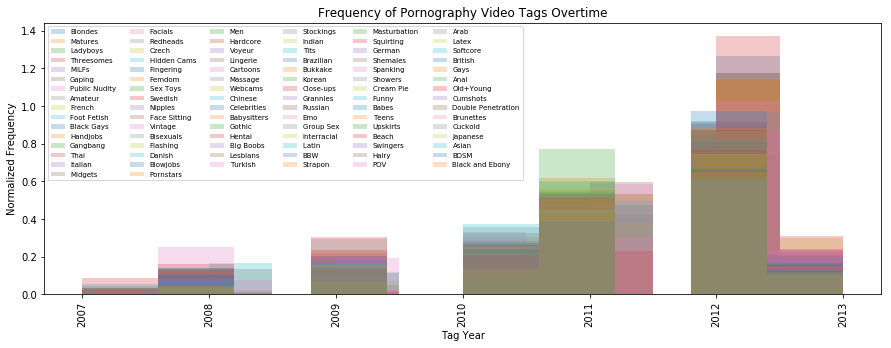

In [10]:
#implement for all tags

def findyears(currenttag):
    currenttagyears = []
    count=0
    for i in tags:
        if currenttag in i:
            currenttagyears.append(videoyears[count])
        count += 1
    return currenttagyears

plt.figure(figsize = (15,5))
for i in alltags:
    taglist = findyears(i)
    plt.hist(np.asarray(taglist), normed = True, alpha = 0.25, label = i)
    
plt.title("Frequency of Pornography Video Tags Overtime")
plt.xticks(rotation=90)
plt.xlabel("Tag Year")
plt.ylabel("Normalized Frequency")
plt.legend(loc='upper left', prop={'size': 7}, ncol = 6)
plt.show()

Since the time trend doesn't appear to tell us much, since most tags seem to follow a similar trend, lets try some more analysis...

In [10]:
from collections import Counter, defaultdict

c=Counter(findyears(alltags[0]))
c_2 = Counter(findyears(alltags[1]))

print("Element counts are:")
print(c)
print("Element counts are:")
print(c_2)
#most common method --- in this case giving most common year
print("Most common elements and their counts are:")
for word, count in c.most_common(1):
    print word, count
print("Most common elements and their counts are:")
for word, count in c_2.most_common(1):
    print word, count

Element counts are:
Counter({'2012': 14377, '2011': 9244, '2010': 5699, '2009': 3944, '2013': 3040, '2008': 2020, '2007': 449})
Element counts are:
Counter({'2012': 14863, '2011': 11140, '2010': 8854, '2009': 6273, '2008': 3751, '2013': 2979, '2007': 236})
Most common elements and their counts are:
2012 14377
Most common elements and their counts are:
2012 14863


In [11]:
from collections import defaultdict

c=Counter(findyears(alltags[0]))

exdict = defaultdict(int)
for year, count in c.items():
    if count > exdict[year]:
        exdict[year] = (count, alltags[0])
exdict['2012'][0]

14377

In [12]:
# try to find the most popular tag each year
counterslist = defaultdict(int)
for tag in alltags:
    c = Counter(findyears(tag))
    for year, count in c.items():
        if counterslist[str(year)] == 0:
            counterslist[year] = (count, tag)
        if count > counterslist[str(year)][0]:
            counterslist[year] = (count, tag)
        
counterslist

defaultdict(int,
            {'2007': (1851, 'Amateur'),
             '2008': (12606, 'Amateur'),
             '2009': (20308, 'Amateur'),
             '2010': (32207, 'Amateur'),
             '2011': (57398, 'Amateur'),
             '2012': (82747, 'Amateur'),
             '2013': (16022, 'Amateur')})

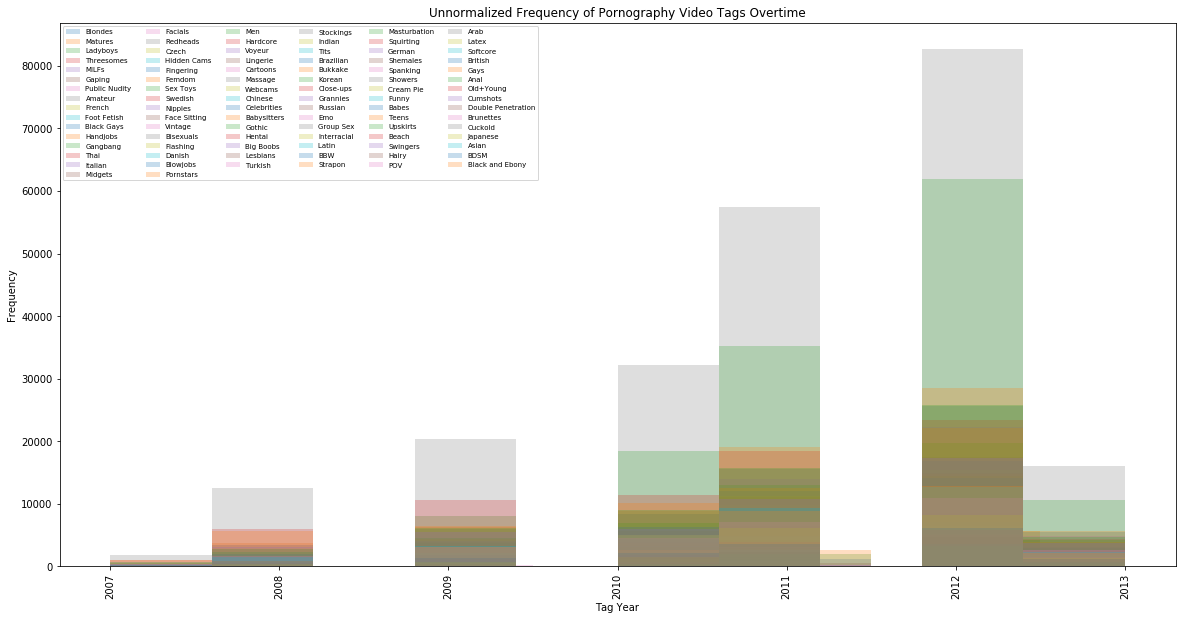

In [11]:
plt.figure(figsize = (20,10))
for i in alltags:
    taglist = findyears(i)
    plt.hist(np.asarray(taglist), alpha = 0.25, label = i)
    
plt.title("Unnormalized Frequency of Pornography Video Tags Overtime")
plt.xticks(rotation=90)
plt.xlabel("Tag Year")
plt.ylabel("Frequency")
plt.legend(loc='upper left', prop={'size': 7}, ncol = 6)
plt.show()

The unnormalized graph confirms that Amateur is most frequently used tag every year... this is a tag that may not be as obviously pornographic, but is clearly popular among porn videos which might be helpful in flagging things online.

In [12]:
#merge datasets
merged_data = youTubeTitles.append(pornTitles, ignore_index=True)
title_matrix= merged_data.loc[:,["title"]]
target_array=merged_data.loc[:, ["isPorn"]]

In [13]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Activation, Dropout

C:\Users\samhelen\Anaconda2\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using CNTK backend
C:\Users\samhelen\Anaconda2\lib\site-packages\keras\backend\cntk_backend.py:21: UserWarning: CNTK backend warning: GPU is not detected. CNTK's CPU version is not fully optimized,please run with GPU to get better performance.
  'CNTK backend warning: GPU is not detected. '


In [15]:
pornarray = pornTitles.values
not_empty = pornTitles.values[:,0] != 1
full_pornarray = pornarray[not_empty]
print len(pornarray)
print len(full_pornarray)
print len(pornarray) - len(full_pornarray)

786121
785329
792


In [16]:
import string

vocab = [x for x in string.ascii_lowercase] + [x for x in string.punctuation] + [x for x in string.digits]
vocab.append(' ')
vocab.append('END')
vocab.append('specialchar')
vocab = set(vocab)
#vocab.append(string.punctuation)
#vocab.append(string.digits)
print vocab
print len(vocab)

set(['specialchar', '!', ' ', '#', '"', '%', '$', "'", '&', ')', '(', '+', '*', '-', ',', '/', '.', '1', '0', '3', '2', '5', '4', '7', '6', '9', '8', ';', ':', '=', '<', '?', '>', '@', 'END', '[', ']', '\\', '_', '^', 'a', '`', 'c', 'b', 'e', 'd', 'g', 'f', 'i', 'h', 'k', 'j', 'm', 'l', 'o', 'n', 'q', 'p', 's', 'r', 'u', 't', 'w', 'v', 'y', 'x', '{', 'z', '}', '|', '~'])
71


In [17]:
# vocab is 71
# create character index

char_index = dict((c, i) for i, c in enumerate(vocab))
print char_index

{'specialchar': 0, '!': 1, ' ': 2, '#': 3, '"': 4, '%': 5, '$': 6, "'": 7, '&': 8, ')': 9, '(': 10, '+': 11, '*': 12, '-': 13, ',': 14, '/': 15, '.': 16, '1': 17, '0': 18, '3': 19, '2': 20, '5': 21, '4': 22, '7': 23, '6': 24, '9': 25, '8': 26, ';': 27, ':': 28, '=': 29, '<': 30, '?': 31, '>': 32, '@': 33, 'END': 34, '[': 35, ']': 36, '\\': 37, '_': 38, '^': 39, 'a': 40, '`': 41, 'c': 42, 'b': 43, 'e': 44, 'd': 45, 'g': 46, 'f': 47, 'i': 48, 'h': 49, 'k': 50, 'j': 51, 'm': 52, 'l': 53, 'o': 54, 'n': 55, 'q': 56, 'p': 57, 's': 58, 'r': 59, 'u': 60, 't': 61, 'w': 62, 'v': 63, 'y': 64, 'x': 65, '{': 66, 'z': 67, '}': 68, '|': 69, '~': 70}


In [18]:
youTubearray = youTubeTitles.values
youTubearray

array([['Eminem - Walk On Water (Audio) ft. Beyonc\xc3\xa9', 0.0],
       ['PLUSH - Bad Unboxing Fan Mail', 0.0],
       ['Racist Superman | Rudy Mancuso, King Bach & Lele Pons', 0.0],
       ...,
       ['Dancing Furry Ball!', 0.0],
       ['Kacey Musgraves - High Horse (Lyric Video)', 0.0],
       ['First footage of deep-sea anglerfish pair', 0.0]], dtype=object)

In [20]:
# combining youtube and porn titles for training -- first 2,000 youtube and first 2,000 porn titles for total of 4,000 titles
titleslist = list(youTubearray[:2500,0]) + list(full_pornarray[:2500,0])
titleslist

['Eminem - Walk On Water (Audio) ft. Beyonc\xc3\xa9',
 'PLUSH - Bad Unboxing Fan Mail',
 'Racist Superman | Rudy Mancuso, King Bach & Lele Pons',
 'I Dare You: GOING BALD!?',
 'Ed Sheeran - Perfect (Official Music Video)',
 'Jake Paul Says Alissa Violet CHEATED with LOGAN PAUL! #DramaAlert Team 10 vs  Martinez Twins!',
 'Vanoss Superhero School - New Students',
 'WE WANT TO TALK ABOUT OUR MARRIAGE',
 'THE LOGANG MADE HISTORY. LOL. AGAIN.',
 'Finally Sheldon is winning an argument about the existence of God',
 '21 Savage - Bank Account (Official Music Video)',
 '12 Weird Ways To Sneak Food Into Class / Back To School Pranks',
 '\xe7\x8c\x8e\xe5\x9c\xba | Game Of Hunting 12\xe3\x80\x90TV\xe7\x89\x88\xe3\x80\x91\xef\xbc\x88\xe8\x83\xa1\xe6\xad\x8c\xe3\x80\x81\xe5\xbc\xb5\xe5\x98\x89\xe8\xad\xaf\xe3\x80\x81\xe7\xa5\x96\xe5\xb3\xb0\xe7\xad\x89\xe4\xb8\xbb\xe6\xbc\x94\xef\xbc\x89',
 'Daang ( Full Video ) | Mankirt Aulakh | Sukh Sanghera | Latest Punjabi Song 2017 | Speed Records',
 'YOUTUBER

In [21]:
maxlength = 0
totallength = 0
count = 0
lengths = []
for title in titleslist:
    currentlength = len(title)
    if currentlength > maxlength:
        maxlength = currentlength
    lengths.append(currentlength)
    totallength += currentlength
    count += 1
print count, totallength, maxlength
avg = totallength/count
print avg

5000 201698 243
40


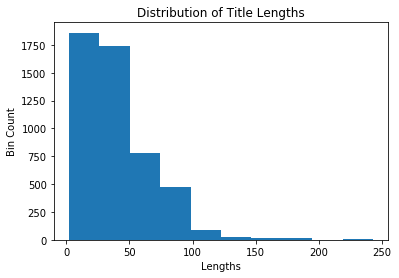

In [22]:
from matplotlib import pyplot as plt

plt.hist(lengths)
plt.title("Distribution of Title Lengths")
plt.xlabel("Lengths")
plt.ylabel("Bin Count")
plt.show()

If we do size 100 majority of titles will be incorporated fully

Edit: 100 is too big (my computer basically crashed LOL) using 50 instead

In [23]:
# one hot encoding
# https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/

#taking first 2000 youtubetitles and first 2000 porntitles to make data more manageable size
encodedlist = []
count = -1
for title in titleslist:
    count += 1
    try:
        int_encoded = [char_index[char] if char in vocab else char_index['specialchar'] for char in title.lower()]
        #make all the title arrays the same size
        if len(title) < 50:
            for i in range(50-len(title)):
                int_encoded.append(char_index["END"])
        onehot_encoded = []
        for value in int_encoded[:50]:
            letter = [0 for _ in range(len(vocab))]
            letter[value] = 1
            onehot_encoded.append(letter)
        encodedlist.append(onehot_encoded)
    except:
        print count, "Problem title:", title
    

In [24]:
print len(encodedlist)

# each title is 100 characters long
print len(encodedlist[0])

# each character vector is 71 characters long
print len(encodedlist[0][0])

5000
50
71


In [25]:
test = [char_index[char] if char in vocab else char_index['specialchar'] for char in titleslist[0].lower()]
for i in range(maxlength-len(title)):
        test.append(char_index["END"])

In [26]:
# pull out isPorn values for training data (first 2000 youtube title values and first porn title values)

total_y = list(youTubeTitles.values[:2500,1]) + list(pornTitles.values[:2500,1])

In [27]:
# encodedlist is train_X
train_x = encodedlist
print np.asarray(train_x).shape

(5000L, 50L, 71L)


In [28]:
train_y = total_y
print np.asarray(train_y).shape
train_y[-2:]

(5000L,)


[1.0, 1.0]

In [29]:
# change one column isPorn Column to 2 columns
# index 0 is porn, index 1 is notporn
# ex. y = [1, 0] is porn, where as y = [0, 1] is not porn

new_train_y = []
for i in train_y:
    if i==1:
        new_train_y.append([1,0])
    else:
        new_train_y.append([0,1])

new_train_y[-2:]

[[1, 0], [1, 0]]

In [30]:
# do same thing for test data

test_titleslist = list(youTubearray[2500:3000,0]) + list(full_pornarray[2500:3000,0])

#taking first 2000 youtubetitles and first 2000 porntitles to make data more manageable size
test_encodedlist = []
count = -1
for title in test_titleslist:
    count += 1
    try:
        int_encoded = [char_index[char] if char in vocab else char_index['specialchar'] for char in title.lower()]
        #make all the title arrays the same size
        if len(title) < 50:
            for i in range(50-len(title)):
                int_encoded.append(char_index["END"])
        onehot_encoded = []
        for value in int_encoded[:50]:
            letter = [0 for _ in range(len(vocab))]
            letter[value] = 1
            onehot_encoded.append(letter)
        test_encodedlist.append(onehot_encoded)
    except:
        print count, "Problem title:", title
    

In [31]:
print len(test_encodedlist)

# each title is 100 characters long
print len(test_encodedlist[0])

# each character vector is 71 characters long
print len(test_encodedlist[0][0])

1000
50
71


In [32]:
test_x = test_encodedlist
test_y = list(youTubeTitles.values[2500:3000,1]) + list(pornTitles.values[2500:3000,1])
print np.asarray(test_x).shape
print np.asarray(test_y).shape

(1000L, 50L, 71L)
(1000L,)


In [33]:
new_test_y = []
for i in test_y:
    if i==1:
        new_test_y.append([1,0])
    else:
        new_test_y.append([0,1])

np.asarray(new_test_y).shape

(1000L, 2L)

In [ ]:
# try to build model based on gender model: https://github.com/prdeepakbabu/Python/blob/master/Deep%20learning%20gender/Deep%20Learning%20(RNN%20-%20LSTMs)%20Predict%20Gender%20from%20Name.ipynb

model = Sequential()
model.add(LSTM(512, return_sequences=True, input_shape = (50, 71)))

# add dropout to avoid overfitting
model.add(Dropout(0.2))
model.add(LSTM(512, return_sequences= False))
model.add(Dropout(0.2))
model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
print model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50, 512)           1196032   
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 512)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1026      
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0         
Total params: 3,296,258
Trainable params: 3,296,258
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(np.asarray(train_x), np.asarray(new_train_y), batch_size = 1000, nb_epoch = 10, validation_data = (np.asarray(test_x), np.asarray(new_test_y)))

Train on 5000 samples, validate on 1000 samples
Epoch 1/10
4000/5000 [=======================>......] - ETA: 1:08 - loss: 0.5745 - acc: 0.7313

In [41]:
score, acc = model.evaluate(np.asarray(test_x), np.asarray(new_test_y))
print 'Test score:', score
print 'Test accuracy:', acc

50/50 [==============================] - 1s 28ms/step
Test score: 0.5922870016098023
Test accuracy: 0.7000000023841858
